# 5. Criação de Modelos de Machine Learning

## Carregar dados tratados

In [117]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [118]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

import joblib

In [119]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

## Feature selection

In [120]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar

In [127]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f"\n{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}\n")

    return X_treino, X_teste, y_treino, y_teste

# ML modelos

## Modelos a serem testados

- AdaBoost
- Gradient Boost
- Rede Neural

In [122]:
def definir_modelos_ml() -> dict:
    modelos = {
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "GradientBoost": GradientBoostingClassifier(random_state=42),
        "RedeNeural": MLPClassifier(random_state= 42),
    }
    print(f"\nModelos a serem comparados: {[v for v in modelos.keys()]}\n")
    return modelos

In [123]:
def treinar_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    modelo_acuracia = {}
    for nome, modelo in modelos.items():
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        
        modelo_acuracia[nome] = avaliar(y_teste, previsoes, f"{nome} Teste")
        modelos[nome] = modelo
    
    return modelo_acuracia

In [124]:
def avaliar(y_teste, y_pred, nome_modelo):
    print(nome_modelo)
    
    report = classification_report(y_teste, y_pred, target_names=["Vender", "Comprar"])
    print(report)
    
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_pred), 
                             index=["Vender", "Comprar"], 
                             columns=["Vender", "Comprar"])
    
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    
    print("Recall:", metrics.recall_score(y_teste, y_pred))
    print("#" * 50)
    return metrics.recall_score(y_teste, y_pred)

In [125]:
def modelos_com_melhores_scores(modelos : dict):
    sort_orders = sorted(modelos.items(), key=lambda x: x[1], reverse=True)
    print(f"Modelos x Recall: {sort_orders[:3]}")

# Execucao

Carregado df com 1852 linhas e 6 colunas.

Colunas carregadas: ['outros_ativos_circ', 'receita_liq', 'despesas_gerais', 'resultado_antes_trib', 'lucro_op', 'decisao']



len(X_treino)=1481 len(X_teste)=371 len(y_treino)=1481 len(y_teste)=371

#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-

Modelos a serem comparados: ['AdaBoost', 'GradientBoost', 'RedeNeural']

AdaBoost Teste
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       186
           1       0.54      0.64      0.59       185

    accuracy                           0.55       371
   macro avg       0.55      0.55      0.55       371
weighted avg       0.55      0.55      0.55       371



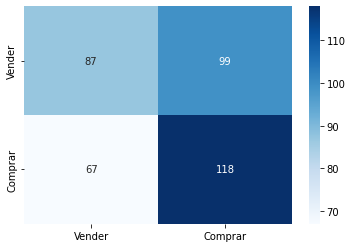

Recall: 0.6378378378378379
##################################################
GradientBoost Teste
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       186
           1       0.55      0.61      0.58       185

    accuracy                           0.56       371
   macro avg       0.56      0.56      0.56       371
weighted avg       0.56      0.56      0.56       371



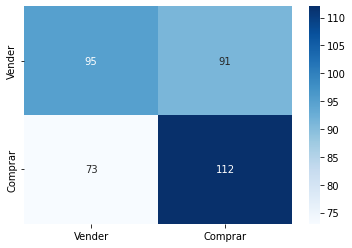

Recall: 0.6054054054054054
##################################################
RedeNeural Teste
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       186
           1       0.56      0.67      0.61       185

    accuracy                           0.58       371
   macro avg       0.58      0.58      0.57       371
weighted avg       0.58      0.58      0.57       371



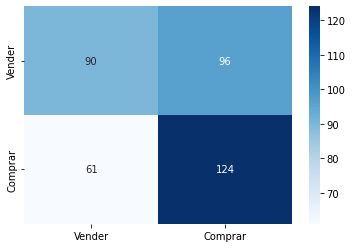

Recall: 0.6702702702702703
##################################################
Modelos x Recall: [('RedeNeural', 0.6702702702702703), ('AdaBoost', 0.6378378378378379), ('GradientBoost', 0.6054054054054054)]


In [128]:
def main():

    df = carregar_joblib()

    print(f"Carregado df com {df.shape[0]} linhas e {df.shape[1]} colunas.\n")
    print(f"Colunas carregadas: {[col for col in df.columns]}\n\n")

    # split database 25% test 75% train
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    print("#-" * 40)

    modelos = definir_modelos_ml()

    modelos_acc = treinar_modelos_ml(modelos, X_treino.values, X_teste.values, y_treino.values, y_teste.values)

    modelos_com_melhores_scores(modelos_acc)

    return df

df = main()

## 3 Melhores modelos - f1-score

- AdaBoost - 60,11%
- RandomForest - 59,84%
- GradientBoost - 59,25%
